In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import sys
sys.path.insert(0, "../")

## Import

In [2]:
import pandas
import numpy

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score

from rep.metaml import FoldingClassifier
from rep.data import LabeledDataStorage
from rep.report import ClassificationReport
from rep.report.metrics import RocAuc

In [3]:
from utils import get_events_number, get_events_statistics

## Reading initial data

In [4]:
import root_numpy
data = pandas.DataFrame(root_numpy.root2array('datasets/MC/csv/Bu_JPsiK/Vertices_Mike.root', selection='vcharge > 0.2'))

## Define label
`label` = `signB` * `signVtx` > 0
* same sign of B and vtx -> label = 1
* opposite sign of B and vtx -> label = 0

In [5]:
event_id_column = 'event_id'
event_id = data.run.apply(str) + '_' + data.event.apply(str)
data['group_column'] = numpy.unique(event_id, return_inverse=True)[1]

# all weights are 1, because this is MC
data['N_sig_sw'] = 1
data[event_id_column] = event_id

In [6]:
data.head()

,run,event,No,mult,nnkrec,Bmass,ptB,vflag,ptmean,ipsmean,...,W_M_svtau,M_pointtheta,W_M_pointtheta,docamax,signB,signVtx,N_sig_sw,BOosc,group_column,event_id
0,2517778,1110822,0,1,4,5.27306,5.05964,2,0.851762,55.706501,...,7.349960,0.046197,0.044500,0.000000,1,-1,1,1,320473,2517778_1110822
1,2517778,1110824,0,1,4,5.27489,11.70600,2,1.564780,8.629360,...,166.444000,0.067733,0.012434,0.000000,1,1,1,0,320474,2517778_1110824
2,2517778,1110869,0,1,1,5.27815,2.78838,2,1.764510,5.588500,...,128503.000000,0.190129,0.017458,0.000000,1,-1,1,0,320475,2517778_1110869
3,2517778,1110880,0,1,2,5.28571,8.92569,6,0.881253,6.912300,...,227.988007,0.029884,0.003415,0.085911,1,1,1,0,320476,2517778_1110880
4,2517778,1110894,0,1,3,5.27156,10.75980,4,0.926523,12.084800,...,57.450001,0.035372,0.010057,0.014691,-1,1,1,0,320477,2517778_1110894


In [7]:
get_events_statistics(data)

{'Events': 550720, 'parts': 552781}

In [8]:
import json
with open('models/JPsiKMC.json', 'r') as f:
    N_B_events = json.load(f)['N_B_events']
N_B_events

1488891.0

In [9]:
N_pass = get_events_number(data)
tagging_efficiency = 1. * N_pass / N_B_events
tagging_efficiency_delta = sqrt(N_pass) / N_B_events
print tagging_efficiency, tagging_efficiency_delta

0.369886042699 0.000498428101082


In [10]:
Bdata_tracks = pandas.read_csv('models/Bdata_tracks_MC.csv')

In [11]:
Bdata_tracks.index = Bdata_tracks.event_id

In [12]:
data['initial_pred'] = Bdata_tracks.ix[data.event_id, 'track_relation_prob'].values

In [13]:
data.ix[numpy.isnan(data['initial_pred'].values), 'initial_pred'] = 1. 

### Define features

In [19]:
data.columns

Index([u'run', u'event', u'No', u'mult', u'nnkrec', u'Bmass', u'ptB', u'vflag',
       u'ptmean', u'ipsmean', u'vcharge', u'svm', u'svp', u'M_BDphiDir',
       u'W_M_BDphiDir', u'M_svtau', u'W_M_svtau', u'M_pointtheta',
       u'W_M_pointtheta', u'docamax', u'signB', u'signVtx', u'N_sig_sw',
       u'BOosc', u'group_column', u'event_id', u'initial_pred'],
      dtype='object')

In [20]:
features =  ['mult', 'nnkrec', 'ptB', 'ipsmean', 'ptmean', 'vcharge', 
             'svm', 'svp', 'M_BDphiDir', 'M_svtau', 'docamax']

In [15]:
data_lds = LabeledDataStorage(data, 1 * (data.signB * data.signVtx > 0), data.N_sig_sw)

## Training

In [16]:
from hep_ml.decisiontrain import DecisionTrainClassifier
from hep_ml.losses import LogLossFunction

In [17]:
from hep_ml.losses import HessianLossFunction
from hep_ml.commonutils import check_sample_weight
from scipy.special import expit

class LogLossFunctionTagging(HessianLossFunction):
    """Logistic loss function (logloss), aka binomial deviance, aka cross-entropy,
       aka log-likelihood loss.
    """  
    def fit(self, X, y, sample_weight):
        self.sample_weight = check_sample_weight(y, sample_weight=sample_weight,
                                                 normalize=True, normalize_by_class=True)
        self.initial_pred = numpy.log(X['initial_pred'].values)
        self.y_signed = 2 * y - 1
        self.minus_y_signed = - self.y_signed
        self.y_signed_times_weights = self.y_signed * self.sample_weight
        HessianLossFunction.fit(self, X, y, sample_weight=self.sample_weight)
        return self

    def __call__(self, y_pred):
        y_pred = y_pred + self.initial_pred
        return numpy.sum(self.sample_weight * numpy.logaddexp(0, self.minus_y_signed * y_pred))

    def negative_gradient(self, y_pred):
        y_pred = y_pred + self.initial_pred
        return self.y_signed_times_weights * expit(self.minus_y_signed * y_pred)

    def hessian(self, y_pred):
        y_pred = y_pred + self.initial_pred
        expits = expit(y_pred)
        return self.sample_weight * expits * (1 - expits)

    def prepare_tree_params(self, y_pred):
        y_pred = y_pred + self.initial_pred
        return self.y_signed * expit(self.minus_y_signed * y_pred), self.sample_weight

In [45]:
tt_base = DecisionTrainClassifier(learning_rate=0.02, n_estimators=3000, depth=6, 
                                  max_features=8,
                                  loss=LogLossFunctionTagging(regularization=100), train_features=features)
tt_folding = FoldingClassifier(tt_base, n_folds=2, random_state=11,
                               features=features + ['initial_pred'])
%time tt_folding.fit_lds(data_lds)
pass

CPU times: user 4min 34s, sys: 472 ms, total: 4min 35s
Wall time: 3min 36s


In [46]:
from scipy.special import expit, logit

In [47]:
p = tt_folding.predict_proba(data)[:, 1]
roc_auc_score(data.signB.values,
              log(data['initial_pred'].values) + logit(p) * data.signB.values,
              sample_weight=data.N_sig_sw.values)

KFold prediction using folds column


0.68290766983758322

### Report for all vtx

In [48]:
report = ClassificationReport({'tt': tt_folding}, data_lds)

KFold prediction using folds column


KFold prediction using folds column


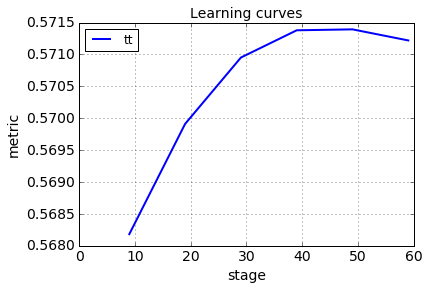

In [49]:
report.learning_curve(RocAuc())

In [50]:
report.compute_metric(RocAuc())

OrderedDict([('tt', 0.57122015644127921)])

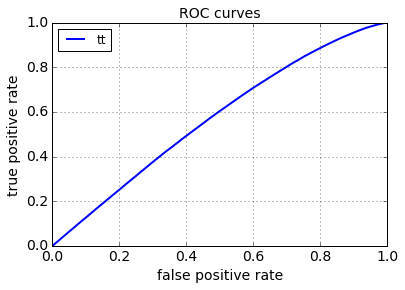

In [51]:
report.roc()

In [53]:
tt_folding.estimators[0].estimators = tt_folding.estimators[0].estimators[:2500]
tt_folding.estimators[1].estimators = tt_folding.estimators[1].estimators[:2500]

--------

## Calibrating results $p(\text{vrt same sign}|B)$ and combining them

In [29]:
models = []

In [30]:
from utils import get_result_with_bootstrap_for_given_part

In [32]:
data['label'] =  1 * (data.signB * data.signVtx > 0)

KFold prediction using folds column


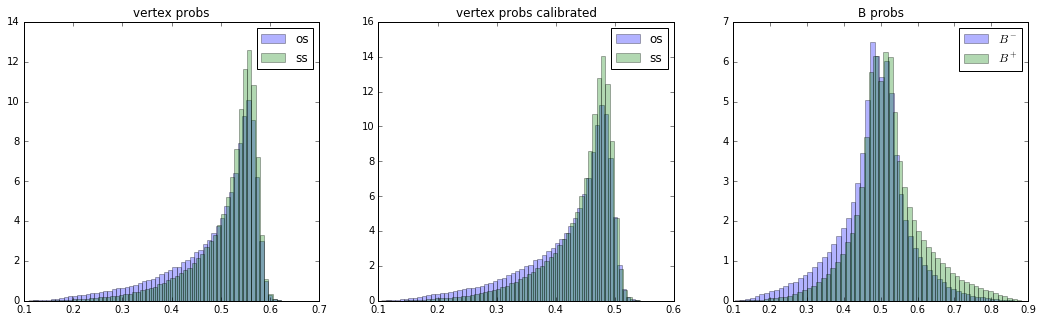

AUC for tagged: 0.605187162372 AUC with untag: 0.546709330325


In [ ]:
result = get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                  [data], 'tt-log', logistic=True, N_B_events=N_B_events, 
                                                  n_calibrations=30, sign_part_column='signVtx', part_name='vertex')
result

KFold prediction using folds column


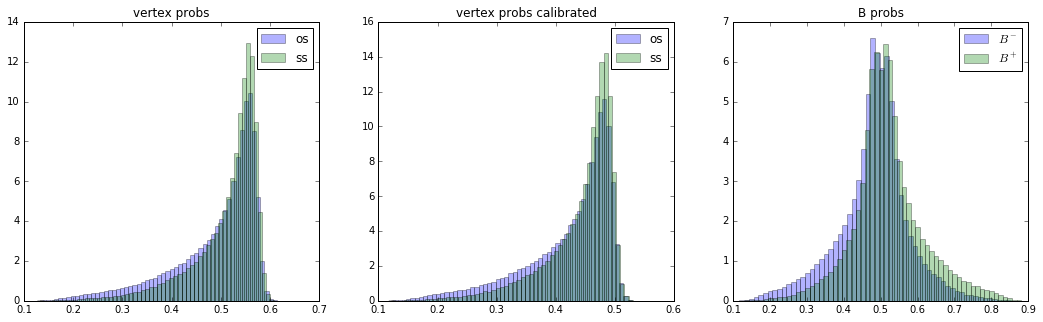

AUC for tagged: 0.60511096162 AUC with untag: 0.546616378757


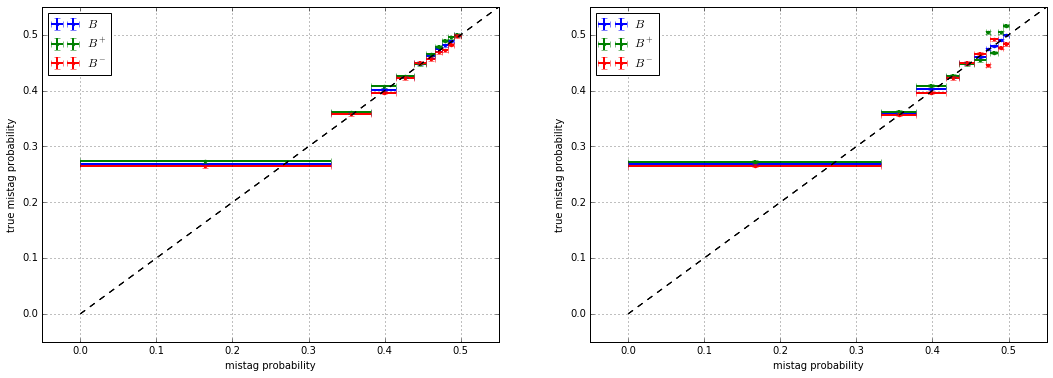

mean AUC after calibration: 0.604944329219 2.68784269792e-09


,name,"$\epsilon_{tag}, \%$","$\Delta \epsilon_{tag}, \%$",$D^2$,$\Delta D^2$,"$\epsilon, \%$","$\Delta \epsilon, \%$","AUC, with untag","$\Delta$ AUC, with untag"
0,tt-log,36.988604,0.049843,0.038955,0.000025,1.440907,0.002147,54.661638,0


In [33]:
result = get_result_with_bootstrap_for_given_part(tagging_efficiency, tagging_efficiency_delta, tt_folding, 
                                                  [data], 'tt-log', logistic=True, N_B_events=N_B_events, 
                                                  n_calibrations=30, sign_part_column='signVtx', part_name='vertex')
result

## Implementing the best vertex model

and saving its predictions

In [34]:
from utils import prepare_B_data_for_given_part

KFold prediction using folds column


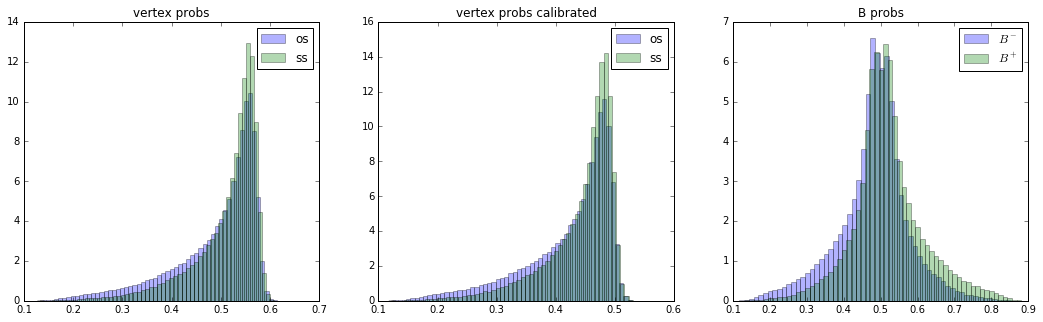

AUC for tagged: 0.60511096162 AUC with untag: 0.546616378757


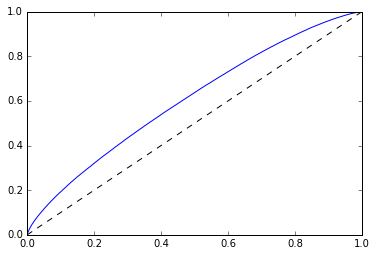

In [36]:
Bdata_prepared = prepare_B_data_for_given_part(tt_folding, [data], N_B_events, logistic=True,
                                               sign_part_column='signVtx', part_name='vertex')

In [37]:
Bdata_prepared.to_csv('models/Bdata_vertex_MC_loss.csv', header=True, index=False)